In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [10]:
# Set plot size 
rcParams['figure.figsize'] = 10, 6

In [14]:
df = pd.read_csv('data/AirPassengers.csv')#.set_index('Month')
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)
df

Shape of the data=  (144, 2)
Column datatypes= 
 Month          object
#Passengers     int64
dtype: object


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [15]:
df['Month'] = pd.to_datetime(df.Month)
df = df.set_index(df.Month)
df.drop('Month', axis = 1, inplace = True)
print('Column datatypes= \n',df.dtypes)
df

Column datatypes= 
 #Passengers    int64
dtype: object


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### Visualise the time series

Text(0.5, 1.0, 'Trend of the Time Series')

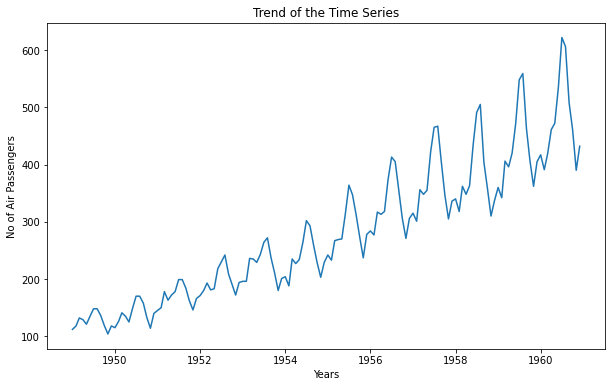

In [16]:
plt.figure(figsize= (10,6))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')
plt.title('Trend of the Time Series')

# Time series Analysis

#### Check for stationarity with Dickey-Fuller test


In [19]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('No of Air Passengers')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

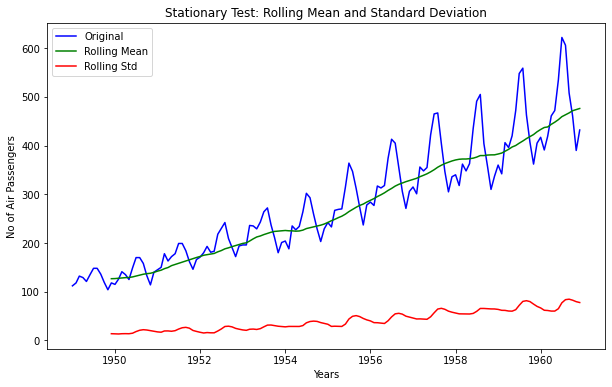

Results of Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [20]:
stationarity_test(df)

#### Differencing

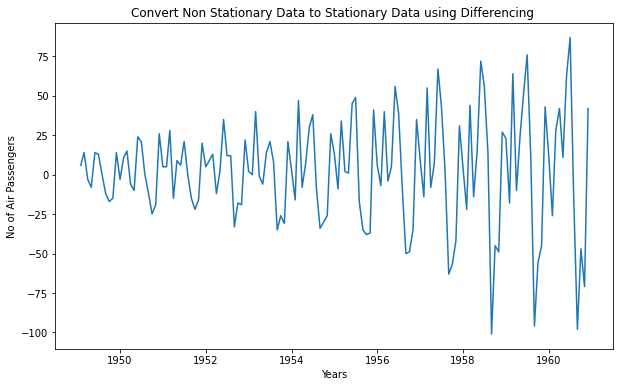

In [21]:
df_diff = df.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_diff)

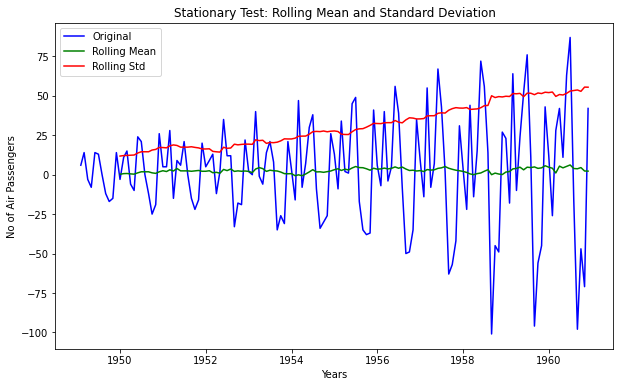

Results of Dickey-Fuller Test
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
df_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_diff)

The rolling values appear to be varying slightly, and we can see there is slight upward trend in standard deviation. Also, the test statistic is smaller than the 10% critical but since p-value is greater than 0.05 it is not a stationary series.

#### Log transformation to make the series stationary

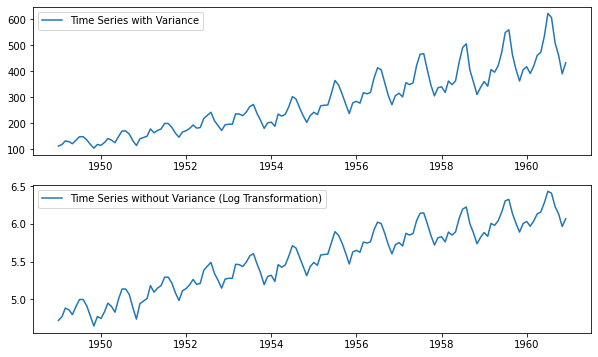

In [23]:
df_log = np.log(df)

plt.subplot(211)
plt.plot(df, label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

log transformation has removed the variance from series

cross-check the differencing method scores with this log transformed data again.

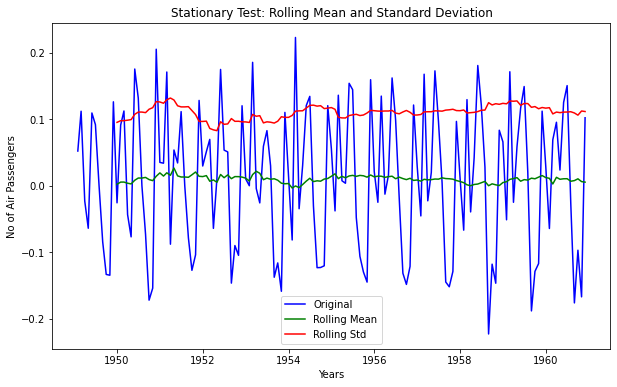

Results of Dickey-Fuller Test
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [24]:
df_log_diff = df_log.diff(periods = 1) # First order differencing

df_log_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_log_diff)

The rolling mean and standard deviation values are okay now. The test statistic is smaller than the 10% critical values but since p-value is greater than 0.05 it is not a stationary series.

#### Take the moving average of the log to make the series stationary

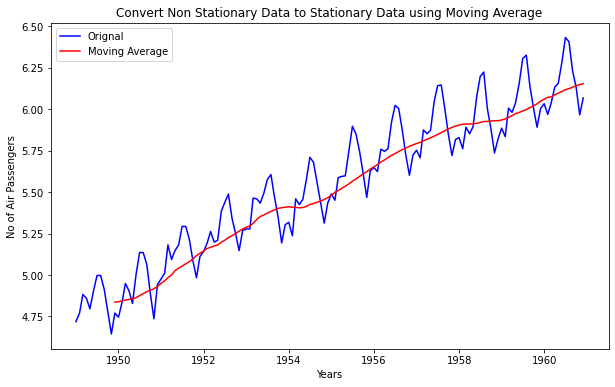

In [25]:
df_log_moving_avg = df_log.rolling(window = 12).mean()
plt.xlabel('Years')
plt.ylabel('No of Air Passengers')    
plt.title('Convert Non Stationary Data to Stationary Data using Moving Average')
plt.plot(df_log, color= 'blue', label='Orignal')
plt.plot(df_log_moving_avg, color= 'red', label='Moving Average')
plt.legend()

As you can see from above graph that data is more smooth without any variance. If we use the differencing technique with log transformed data and mean average data then we should get better stationarity scores

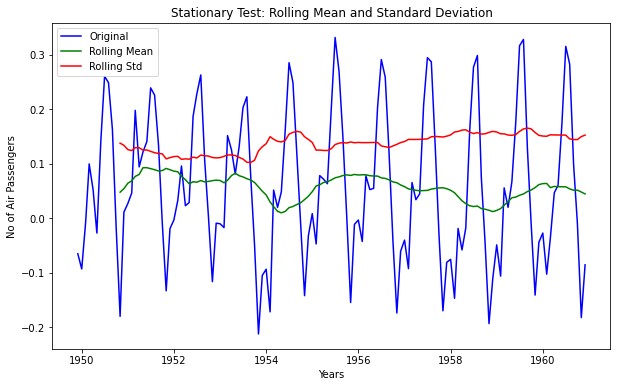

Results of Dickey-Fuller Test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [26]:
df_log_moving_avg_diff = df_log - df_log_moving_avg
df_log_moving_avg_diff.dropna(inplace = True)
stationarity_test(df_log_moving_avg_diff)

p-value is less than 0.05 that means our series is stationary, but we can only say this with 95% of confidence, as test statistics is less than 5% critical value.

In order to increase the stationarity of the series lets try to use 'Weighted Moving Average' technique

#### Weighted Moving Average (WMA)

Here we are going to use exponentially weighted moving average with parameter ‘halflife = 12’. This parameter defines the amount of exponential decay. 

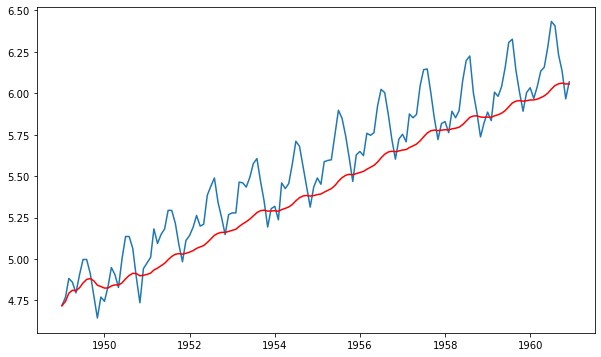

In [27]:
df_log_weighted_avg = df_log.ewm(halflife = 12).mean()
plt.plot(df_log)
plt.plot(df_log_weighted_avg, color = 'red')

Notice that WMA follow's no of passenger values more closely than a corresponding Simple Moving Average which also results in more accurate trend direction. Now lets check, the effect of this on stationarity scores!

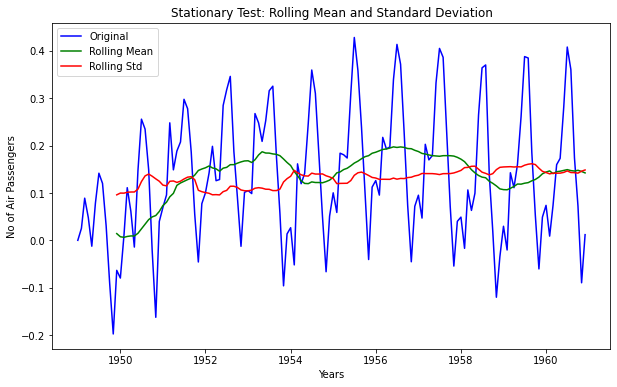

Results of Dickey-Fuller Test
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [28]:
df_log_weighted_avg_diff = df_log - df_log_weighted_avg
stationarity_test(df_log_weighted_avg_diff)

### Time series decomposition technique

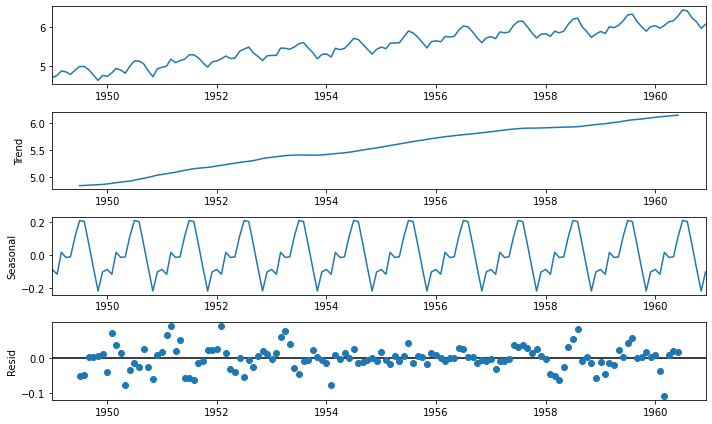

In [29]:
decomposition = sm.tsa.seasonal_decompose(df_log,period =12)
fig = decomposition.plot()

Here we can see that the trend and seasonality are separated out from log transformed data, and we can now check the stationarity of the residuals

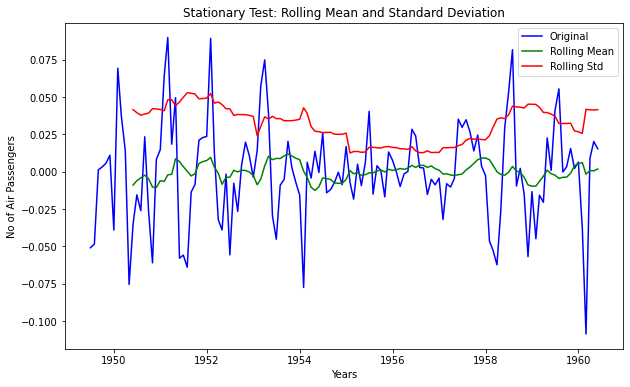

Results of Dickey-Fuller Test
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [30]:
df_log_residual = decomposition.resid
df_log_residual.dropna(inplace = True)
stationarity_test(df_log_residual)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value and p-value is almost 0. So this time series is very close to stationary. This concludes our time series analysis and data transformation to get the stationary series. Now we can start modeling it for forecast.

## Forecasting with ARIMA


- We are using df_log_diff series
- Find p and q parameters of the AR and MA models



### ACF and PACF Plots
- To figure out the order of AR model(p) we will use PACF function. p = the lag value where the PACF chart crosses the upper confidence interval for the first time
- To figure out the order of MA model(q) we will use ACF function. q = the lag value where the ACF chart crosses the upper confidence interval for the first time

C:\Users\ruk01\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


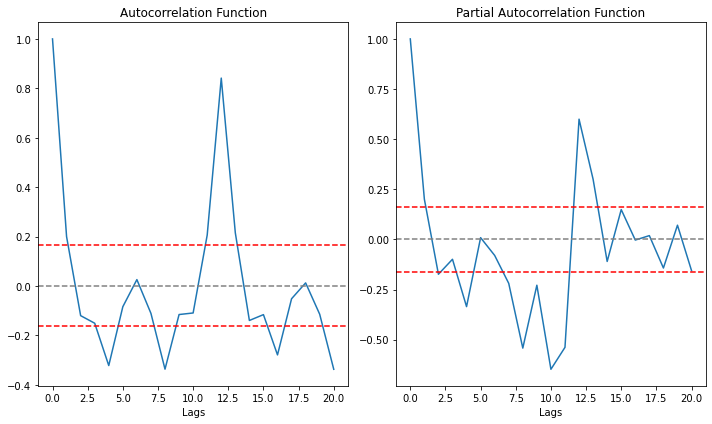

In [31]:
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

As there many significant spikes there can be many options for p,q parameters. We choose 2,2 for simplicity

C:\Users\ruk01\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Text(0.5, 1.0, 'Combined Model, RSS: 1.0292')

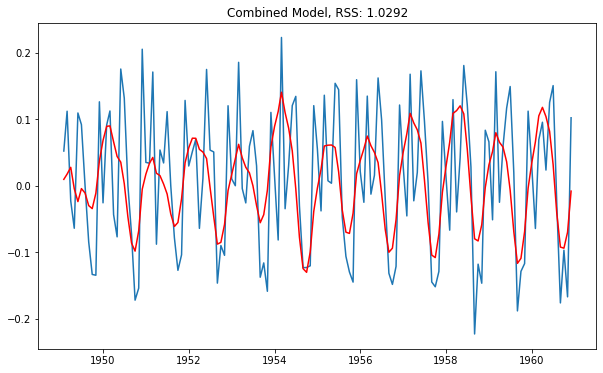

In [33]:
model = ARIMA(df_log, order=(2, 1, 2), freq = 'MS')  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Combined Model, RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_log_diff['#Passengers'])**2))

#### Predictions

In [34]:
predictions_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

print('Total no of predictions: ', len(predictions_diff))
predictions_diff.head()

Total no of predictions:  143


Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In order to remove 'differencing transformation' from the prediction values we are going to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. We are going to use pandas cumsum() function for it.

In [35]:
predictions_diff_cumsum = predictions_diff.cumsum()
predictions_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [44]:
predictions_log = pd.Series(df_log['#Passengers'].iloc[0], index=df_log.index) # Series of base number
predictions_log = predictions_log.add(predictions_diff_cumsum,fill_value=0)
predictions_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

#### Inverse log transformation

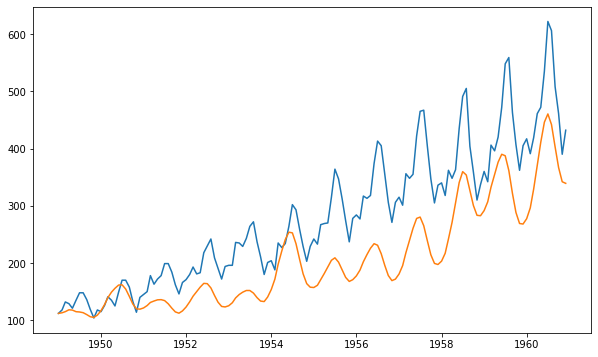

In [45]:
predictions = np.exp(predictions_log)
plt.plot(df)
plt.plot(predictions)

In [46]:
df_predictions =pd.DataFrame(predictions, columns=['Predicted Values'])
pd.concat([df,df_predictions],axis =1).Tdf_predictions =pd.DataFrame(predictions, columns=['Predicted Values'])
pd.concat([df,df_predictions],axis =1).T

<ipython-input-46-4eacfe42d7b1>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pd.concat([df,df_predictions],axis =1).Tdf_predictions =pd.DataFrame(predictions, columns=['Predicted Values'])


Month,1949-01-01,1949-02-01,1949-03-01,1949-04-01,1949-05-01,1949-06-01,1949-07-01,1949-08-01,1949-09-01,1949-10-01,...,1960-03-01,1960-04-01,1960-05-01,1960-06-01,1960-07-01,1960-08-01,1960-09-01,1960-10-01,1960-11-01,1960-12-01
#Passengers,112.0,118.000000,132.000000,129.000000,121.000000,135.000000,148.000000,148.000000,136.000000,119.000000,...,419.000000,461.000000,472.000000,535.000000,622.000000,606.000000,508.000000,461.000000,390.000000,432.000000
Predicted Values,112.0,113.078121,115.073414,118.301987,117.768363,114.988271,114.489517,113.239572,109.900647,106.177201,...,329.211834,370.427681,411.048948,446.084207,460.459711,441.884865,402.904459,366.752159,341.983534,339.215532


### Forcasting for the future

- We have data from 1 Jan 1949 to 1 Dec 1960. 12 years of data with passenger number observation for each month i.e. 144 total observations.
- If we want to forecast for next 5 years or 60 months then, ‘end’ count will be > 144 + 60 = 204.
- We are going to use statsmodels plot_predict() method for it

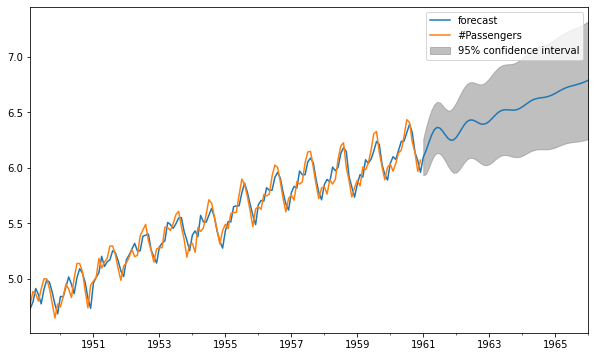

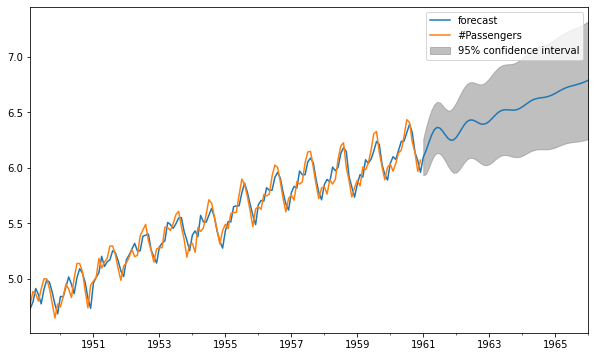

In [47]:
results_ARIMA.plot_predict(start = 1, end= 204) 

In [48]:
# Forecasted values in original scale will be
forecast_values_log_scale = results_ARIMA.forecast(steps = 60)
forecast_values_original_scale = np.exp(forecast_values_log_scale[0])

forecast_date_range= pd.date_range("1961-01-01", "1965-12-01", freq="MS")

df_forecast =pd.DataFrame(forecast_values_original_scale, columns=['Forecast'])
df_forecast['Month'] = forecast_date_range

df_forecast[['Month', 'Forecast']]

,Month,Forecast
0,1961-01-01,443.870975
1,1961-02-01,470.038230
2,1961-03-01,504.934976
3,1961-04-01,540.454801
4,1961-05-01,567.730677
5,1961-06-01,580.328069
6,1961-07-01,577.002615
7,1961-08-01,561.938811
8,1961-09-01,542.384585
9,1961-10-01,525.566668
